# WIKI-SHEAF

@ Alessio Borgi
@ Stefano Previti

### 0: IMPORTING LIBRARIES

In [1]:
!pip install requests datasets networkx matplotlib torch torch-geometric sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
### LIBRARIES NECESSARY FROM STEP 0 ON ###
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

# Only necessary if you take the dataset from the drive instead from HuggingFace.
from google.colab import drive
drive.mount('/content/drive')

### LIBRARIES NECESSARY FROM STEP 2 ON ###
import torch
import random
import itertools
import networkx as nx
from torch_geometric.utils import from_networkx
from sklearn.feature_extraction.text import TfidfVectorizer

import os
import torch
import numpy as np
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Sequential, ReLU, Dropout
from sklearn.metrics import precision_score, recall_score, f1_score
from torch_geometric.nn import GCNConv, BatchNorm, GATConv, SAGEConv, GINConv


#import torch
#import torch.nn.functional as F
#import matplotlib.pyplot as plt
#from torch_geometric.data import HeteroData
#from torch_geometric.utils import to_networkx
#from sentence_transformers import SentenceTransformer





ValueError: mount failed

### 0.5: TRAINING SET LOADING, INSPECTION & DISCOVERY

We make some exploration from the dataset. In the first version of the data provided, we noticed the following "issues". The first and second problems have been solved with the introduction of the new dataset version, while the third and fourth (actually not being problems, but dataset features), still persist.

**NaN LABEL PRESENCE**

As first thing we noticed that there are 7 rows that are all missing the "label" value.
- We decide to eliminate directly these lines since they are both not useful if they are not providing a label and are only very few outliers (7/6251), due to maybe errors in the labeling step.

**LABEL INCONSISTENCIES**

The list of the labels are not actually really containig only 3 labels. Indeed, by making a set operation over the "labels" column, we noticed that it contains: *{'cultural exclusive', 'cultural', 'cultural agnostic', 'cult', 'cultural representative', 'cultural agn', 'cultural represent', 'cultural ex', 'cultural ag'}*.
  - We decided to counteract this issue by **mantaining only the 3 labels** *{'cultural exclusive', 'cultural representative', 'cultural agnostic'}*.
  - For the lines whose labels are *{'cultural agn', 'cultural ag'}*, the labels are sobstituted with "cultural agnostic".
  - For the lines whose labels are *{'cultural represent'}*, the labels are sobstituted with *{'cultural representative'}*.
  - For the lines whose labels are *{'cultural ex'}*, the labels are sobstituted with *{'cultural exclusive'}*.
  - For the lines whose labels are *{'cultural', 'nan', 'cult'}*, we decided to directly drop them.

(Notice that these labels inconsistencies are really outliers. Indeed, we will remain with out dataset being **6238 samples** long).

**CLASS IMBALANCE**

After this cleaning, we notice that the samples we have at our disposal is not provided in an equal manner, but we have instead a **Class Imbalance** issue, Due to the fact that this is not so imbalanced, we decide to just take this into account at **Training Time**, in the future model, by using a **Class Weighting** in the **Loss Function** (e.g., *Weighted Cross-Entropy*).

**NAME DUPLICATES**

We also notice that the dataset contains duplicates in the "name" column, meaning that there are some words that have a different meaning depending on the context. Since these are very few, we decide to mantain them and not to delete them (also because would be wrong to do this).



##### 0.5.0: UTILS FUNCTIONS

In [ ]:
def check_nan_labels(df):
    ''' Util function to check nan label presence. '''

    # 1) Count missing values per column and print them out.
    print("=== NaN LABEL PRESENCE ===")
    missing_counts = df.isnull().sum()
    total_missing = missing_counts.sum()
    print(f"Total missing values in the DataFrame: {total_missing}\n")
    print("Missing values by column:")
    print(missing_counts)
    print("\nRows with missing values and the respective columns:")
    for idx, row in df.iterrows():
        missing_cols = row[row.isnull()].index.tolist()
        if missing_cols:
            print(f"Row {idx}: {missing_cols}")

    # 2) SOLUTION ADOPTED: Drop the rows containing NaN.
    print("DataFrame shape before dropping rows with NaN:", df.shape)
    df = df.dropna()
    print("DataFrame shape after dropping rows with NaN:", df.shape)
    print("====== END =====\n")
    return df

In [ ]:
def check_labels_inconsistencies(df):
    ''' Utils function to check whether the labels present inconsistencies. '''

    print("=== LABEL INCONSISTENCIES PRESENCE ===")
    # 1) Label Inconsistencies discovery.
    print("Original unique labels:")
    print(set(df["label"].dropna().unique()))

    # Make a copy of the DataFrame to avoid SettingWithCopyWarning.
    df_clean = df.copy()

    # 2) Define the mapping for substitutions and replace labels.
    mapping = {
        "cultural agn": "cultural agnostic",
        "cultural ag": "cultural agnostic",
        "cultural represent": "cultural representative",
        "cultural ex": "cultural exclusive"
    }

    df_clean.loc[:, "label"] = df_clean["label"].replace(mapping)

    # 3) Drop the ambiguous rows.
    drop_set = {"cultural", "cult"}
    print("DataFrame shape before dropping rows with ambiguous labels:", df_clean.shape)
    df_clean = df_clean[~df_clean["label"].isin(drop_set)]
    print("DataFrame shape after dropping rows with ambiguous labels:", df_clean.shape)

    valid_labels = {"cultural exclusive", "cultural representative", "cultural agnostic"}
    df_clean = df_clean[df_clean["label"].isin(valid_labels)]

    print("\nUnique labels after cleaning:")
    print(set(df_clean["label"].unique()))
    df = df_clean.copy()
    print("====== END =====\n")
    return df

In [ ]:
def visualize_class_imbalance(df):
    ''' Utils function to visualize the Class Imbalance Distribution with a Histogram. '''
    # 1) Count the occurrences of each label.
    label_counts = df["label"].value_counts()
    print("\nLabel Counts:")
    print(label_counts)

    # 2) Visualize the label distribution.
    plt.figure(figsize=(8, 6))
    label_counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Labels in the Dataset (After Cleaning)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def check_duplicates(df):
    ''' Utils function to check for duplicates. '''
    # Check for duplicates in the "name" column.
    duplicate_mask = df["name"].duplicated(keep=False)
    duplicates = df.loc[duplicate_mask, "name"].unique()
    print("Cells that are not unique in column 'name':")
    print(duplicates)

#### 0.5: OLD-VERSION (DATASET)

##### 0.5.0: SETUP STEP

In [ ]:
### SETUP STEP ###

# ADJUST VALUES ACCORDING TO YOUR CASE #

# Adjust the path to the training dataset(file) according to your directory structure.
file_path = '/content/drive/MyDrive/MNLP/HW1/[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv'


In [ ]:
# 1) Load the TSV file into a Pandas DataFrame.
df = pd.read_csv(file_path, delimiter='\t', encoding='utf-8')
df.head()


,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative


##### 0.5.1: NaN LABEL PRESENCE

In [ ]:
df = check_nan_labels(df)

=== NaN LABEL PRESENCE ===
Total missing values in the DataFrame: 7

Missing values by column:
item           0
name           0
description    0
type           0
category       0
subcategory    0
label          7
dtype: int64

Rows with missing values and the respective columns:
Row 1214: ['label']
Row 1651: ['label']
Row 2831: ['label']
Row 3236: ['label']
Row 4853: ['label']
Row 5885: ['label']
Row 6063: ['label']
DataFrame shape before dropping rows with NaN: (6251, 7)
DataFrame shape after dropping rows with NaN: (6244, 7)
====== END =====



##### 0.5.2: LABEL INCONSISTENCIES

In [ ]:
df = check_labels_inconsistencies(df)


=== LABEL INCONSISTENCIES PRESENCE ===
Original unique labels:
{'cultural ag', 'cultural', 'cultural agn', 'cultural ex', 'cultural represent', 'cultural exclusive', 'cultural agnostic', 'cultural representative', 'cult'}
DataFrame shape before dropping rows with ambiguous labels: (6244, 7)
DataFrame shape after dropping rows with ambiguous labels: (6238, 7)

Unique labels after cleaning:
{'cultural agnostic', 'cultural representative', 'cultural exclusive'}
====== END =====



##### 0.5.3: CLASS IMBALANCE


Label Counts:
label
cultural exclusive         2686
cultural agnostic          1866
cultural representative    1686
Name: count, dtype: int64


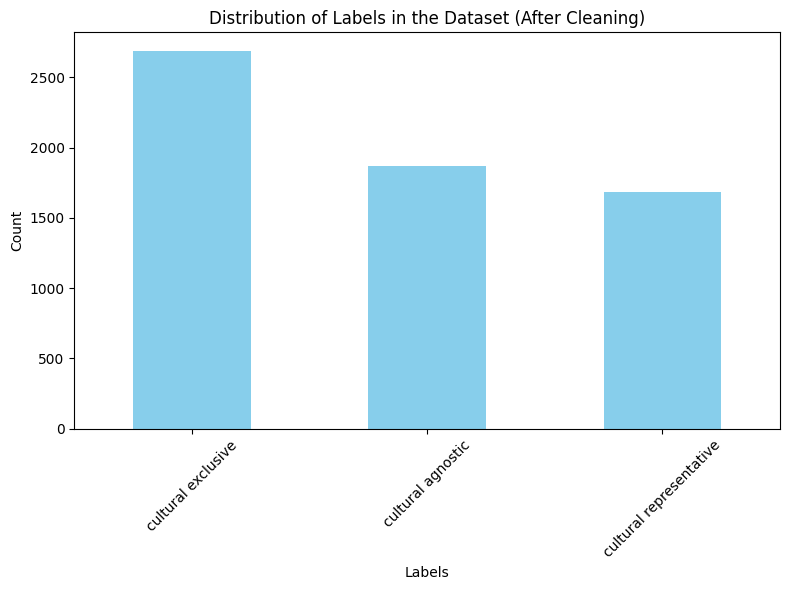

In [ ]:
visualize_class_imbalance(df)

##### 0.5.4: DUPLICATES DISCOVERY

In [ ]:
check_duplicates(df)

Cells that are not unique in column 'name':
['prefect' 'Pirate Party' 'Socialist Party' 'central government'
 'Breithorn' 'Alexandria']


##### 0.5.5: CLEANED DATASET INFORMATION


In [ ]:
# 1) Display basic DF information.
print("=== DataFrame Info ===")
df.info()



=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
Index: 6238 entries, 0 to 6250
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item         6238 non-null   object
 1   name         6238 non-null   object
 2   description  6238 non-null   object
 3   type         6238 non-null   object
 4   category     6238 non-null   object
 5   subcategory  6238 non-null   object
 6   label        6238 non-null   object
dtypes: object(7)
memory usage: 389.9+ KB


In [ ]:
# 2) Display DF Staistics.
print("\n=== DataFrame Statistics===")
print(df.describe())


=== DataFrame Statistics===
                                         item                name description  \
count                                    6238                6238        6238   
unique                                   6238                6232        5659   
top     http://www.wikidata.org/entity/Q67094  central government  film genre   
freq                                        1                   2          32   

          type  category subcategory               label  
count     6238      6238        6238                6238  
unique       2        19         108                   3  
top     entity  politics  politician  cultural exclusive  
freq      3919       532          99                2686  


In [ ]:
# 3) Check for duplicate rows
duplicate_mask = df.duplicated()
num_duplicates = duplicate_mask.sum()
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("Duplicate rows:")
    print(df[duplicate_mask])

# (DUPLICATES NOT PRESENT) !

Number of duplicate rows: 0


In [ ]:
# 4) Checking that we have really 19 categories, and also checking the according subcategories.
unique_categories = df["category"].unique()
unique_subcategories = df["subcategory"].unique()

print("Unique Categories:")
print(unique_categories)
print(len(unique_categories))
print("\nUnique Subcategories:")
print(unique_subcategories)
print(len(unique_subcategories))



Unique Categories:
['politics' 'food' 'architecture' 'transportation' 'sports' 'media'
 'philosophy and religion' 'literature' 'visual arts' 'fashion'
 'comics and anime' 'performing arts' 'music' 'films' 'books' 'history'
 'gestures and habits' 'biology' 'geography']
19

Unique Subcategories:
['politician' 'political party' 'government agency' 'law' 'policy'
 'government' 'food' 'drink' 'dish' 'ingredient' 'cook'
 'cooking technique' 'architectural structure' 'architectural style'
 'architect' 'construction' 'building' 'building material'
 'transport company' 'automobile manufacturer' 'transport'
 'mode of transport' 'station' 'athlete' 'sports team' 'sport'
 'sports club' 'recurring sporting event' 'sports equipment'
 'media company' 'magazine' 'television' 'production company'
 'film studio' 'streaming service' 'philosopher' 'religious leader'
 'religion' 'philosophy' 'philosophical movement' 'religious movement'
 'poetry' 'poet' 'writing style' 'literary genre' 'literary award'
 'w

In [ ]:
# 5) Category-SubCategories Dictionary construction.
cat_subcat_dict = df.groupby("category")["subcategory"].unique().to_dict()

print("Categories and their subcategories:")
for cat, subcats in cat_subcat_dict.items():
    print(f"Category: {cat} -> Subcategories: {list(subcats)} (Count: {len(subcats)})")

Categories and their subcategories:
Category: architecture -> Subcategories: ['architectural structure', 'architectural style', 'architect', 'construction', 'building', 'building material'] (Count: 6)
Category: biology -> Subcategories: ['organism', 'biologist', 'animal', 'tree', 'plant', 'fish'] (Count: 6)
Category: books -> Subcategories: ['book', 'bookstore', 'non-fiction writer'] (Count: 3)
Category: comics and anime -> Subcategories: ['comics', 'comics artist', 'manga', 'animated film', 'animation technique', 'animation studio'] (Count: 6)
Category: fashion -> Subcategories: ['clothing', 'traditional costume', 'designer', 'fashion trend', 'textile', 'model'] (Count: 6)
Category: films -> Subcategories: ['film', 'film festival', 'film director', 'film producer', 'film genre'] (Count: 5)
Category: food -> Subcategories: ['food', 'drink', 'dish', 'ingredient', 'cook', 'cooking technique'] (Count: 6)
Category: geography -> Subcategories: ['geographic location', 'environment', 'mountai


Counts for each Category:
category
politics                   532
sports                     428
geography                  408
philosophy and religion    394
architecture               394
literature                 362
music                      348
food                       345
fashion                    319
visual arts                312
comics and anime           311
history                    304
media                      285
biology                    285
performing arts            275
films                      269
gestures and habits        259
transportation             217
books                      191
Name: count, dtype: int64

Counts for each Subcategory:
subcategory
politician           99
law                  95
film                 95
government agency    94
ritual               94
                     ..
environment           5
writing style         4
cooking technique     4
fashion trend         4
body language         1
Name: count, Length: 108, dtype: int64


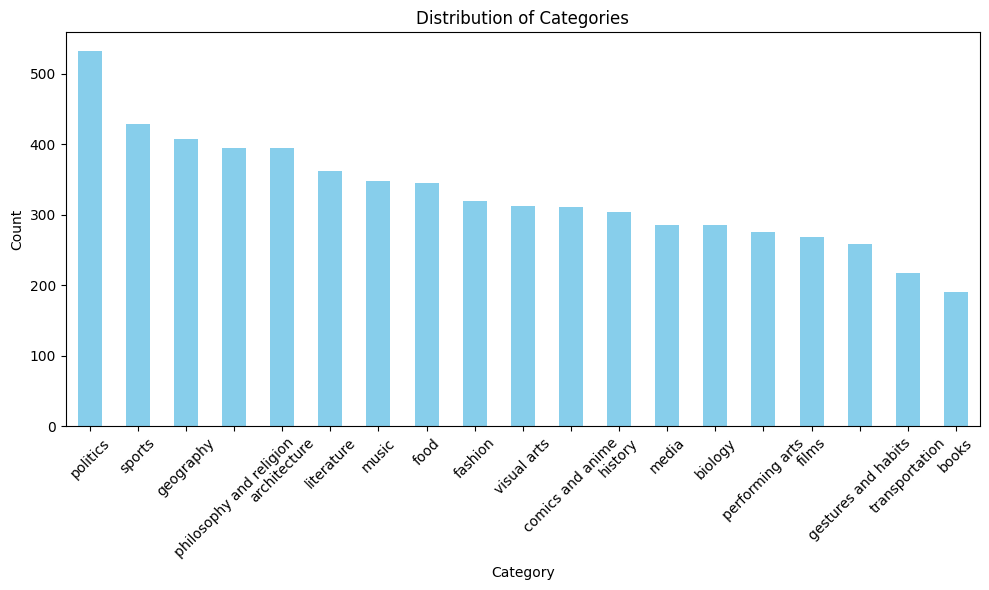

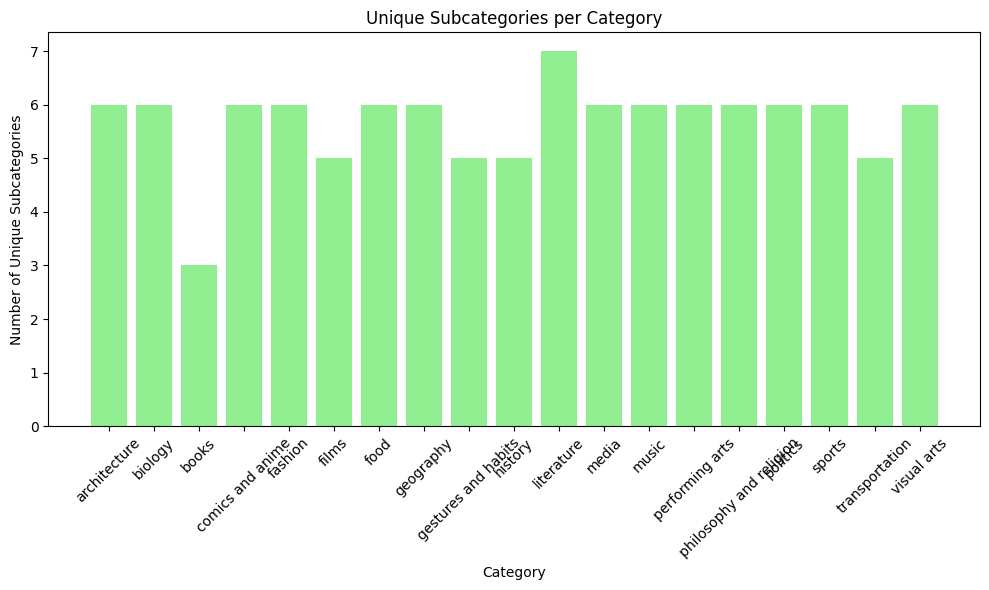

In [ ]:
# 6) Additionally, print counts of entries for each category.
category_counts = df["category"].value_counts()
print("\nCounts for each Category:")
print(category_counts)

# And for each subcategory
subcategory_counts = df["subcategory"].value_counts()
print("\nCounts for each Subcategory:")
print(subcategory_counts)

# Visualize the distribution of the main categories.
category_counts = df["category"].value_counts()
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar', color='skyblue')
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize the number of unique subcategories for each main category.
subcat_counts = {cat: len(subcats) for cat, subcats in cat_subcat_dict.items()}
plt.figure(figsize=(10,6))
plt.bar(subcat_counts.keys(), subcat_counts.values(), color='lightgreen')
plt.xlabel("Category")
plt.ylabel("Number of Unique Subcategories")
plt.title("Unique Subcategories per Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### 0.5.6: SAVE MODIFIED DATAFRAME (CSV)

In [ ]:
df.to_csv("dataframe.csv", index=False)

#### 0.5: NEW VERSION (DATASET)

##### 0.5.0: SETUP STEP

In [ ]:
# Login beforehand using huggingface-cli login if necessary.
ds = load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")
train_data = ds["train"]
validation_data = ds["validation"]

# Create Pandas Dataframes just for better analysis.
train_df = train_data.to_pandas()
validation_df = validation_data.to_pandas()


In [ ]:
train_df.head()

In [ ]:
validation_df.head()

##### 0.5.1: NaN LABEL PRESENCE

In [ ]:
df_train = check_nan_labels(train_df)
df_validation = check_nan_labels(validation_df)


##### 0.5.2: LABEL INCONSISTENCIES

In [ ]:
train_df = check_labels_inconsistencies(train_df)
validation_df = check_labels_inconsistencies(validation_df)

##### 0.5.3: CLASS IMBALANCE

In [ ]:
visualize_class_imbalance(train_df)
visualize_class_imbalance(validation_df)

##### 0.5.4: DUPLICATES DISCOVERY

In [ ]:
check_duplicates(train_df)
check_duplicates(validation_df)

##### 0.5.5: CLEANED DATASET INFORMATION


In [ ]:
# 1) Display basic DF information.
print("=== Training DataFrame Info ===")
train_df.info()

print("=== Validation DataFrame Info ===")
validation_df.info()

In [ ]:
# 2) Display DF Staistics.
print("\n=== Training DataFrame Statistics===")
print(train_df.describe())

print("\n=== Validation DataFrame Statistics===")
print(validation_df.describe())

In [ ]:
# 3) Check for duplicate rows
duplicate_mask = train_df.duplicated()
num_duplicates = duplicate_mask.sum()
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("Duplicate rows:")
    print(df[duplicate_mask])

# (DUPLICATES NOT PRESENT) !

In [ ]:
# 4) Checking that we have really 19 categories, and also checking the according subcategories.
unique_categories = train_df["category"].unique()
unique_subcategories = train_df["subcategory"].unique()

print("Unique Categories:")
print(unique_categories)
print(len(unique_categories))
print("\nUnique Subcategories:")
print(unique_subcategories)
print(len(unique_subcategories))



In [ ]:
# 5) Category-SubCategories Dictionary construction.
cat_subcat_dict = train_df.groupby("category")["subcategory"].unique().to_dict()

print("Categories and their subcategories:")
for cat, subcats in cat_subcat_dict.items():
    print(f"Category: {cat} -> Subcategories: {list(subcats)} (Count: {len(subcats)})")

In [ ]:
# 6) Additionally, print counts of entries for each category.
category_counts = train_df["category"].value_counts()
print("\nCounts for each Category:")
print(category_counts)

# And for each subcategory
subcategory_counts = train_df["subcategory"].value_counts()
print("\nCounts for each Subcategory:")
print(subcategory_counts)

# Visualize the distribution of the main categories.
category_counts = train_df["category"].value_counts()
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar', color='skyblue')
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize the number of unique subcategories for each main category.
subcat_counts = {cat: len(subcats) for cat, subcats in cat_subcat_dict.items()}
plt.figure(figsize=(10,6))
plt.bar(subcat_counts.keys(), subcat_counts.values(), color='lightgreen')
plt.xlabel("Category")
plt.ylabel("Number of Unique Subcategories")
plt.title("Unique Subcategories per Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2: GRAPH CONSTRUCTION

####2.1: BASELINE - TF–IDF + Category/Subcategory Clique Graph

In this first **Baseline**, we represent each cultural item as a node in a **homogeneous graph**, using its name and description to build a **1 000‑dimensional TF–IDF(Term Frequency–Inverse Document Frequency) feature vector**.  **Edges** are then added by **fully connecting (“clique‐ing”)** all items that share the same high‑level category or fine‑grained subcategory, encoding cultural similarity purely via our provided taxonomy.  We also create train/validation masks on the nodes so that downstream GNNs can be trained and evaluated in a standard node‐classification setup. Notice that this is just a very basic construction that provides only a starting point before moving on to more sophisticated graph types or feature enhancements.  

--------------------------
**TF–IDF FEATURE VECTOR**

*(Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)*

In this baseline graph, each node corresponds to a cultural item with two text fields: **name** and **description**.  To turn these into fixed‑length numeric features that capture the most distinctive words for each item, we compute a **TF–IDF** vector.

- **Tokenization and Vocabulary:** The *TfidfVectorizer* we employ, by default:
  - Splits each “name + description” string on whitespace and punctuation.
  - Converts all text to lowercase.
  - Builds a vocabulary of the top `max_features` $(\leq 1\,000)$ terms ranked by overall TF–IDF score.

- **Term Frequency (TF):** For a given item $d$ and term $t$, we have that this captures how often $t$ appears **within** this item’s text.
:
$$\begin{equation}
  \mathrm{TF}(t, d) \;=\; \frac{\text{count of }t\text{ in }d}{\text{total terms in }d}.
  \end{equation}
$$

- **Inverse Document Frequency (IDF):** Over the entire corpus of $N$ items  (with $\lvert\{d : t \in d\}\rvert$ being the number of items containing $t$), we have that rarer terms get a higher IDF weight.:
$$\begin{equation}
  \mathrm{IDF}(t) \;=\; \log\!\Bigl(\frac{N}{1 + \lvert\{\,d : t \in d\}\rvert}\Bigr),
  \end{equation}
$$

- **Combining TF and IDF:** The **TF–IDF** weight for term \(t\) in document \(d\) is:
$$\begin{equation}
  \mathrm{TF\mbox{–}IDF}(t, d) \;=\; \mathrm{TF}(t, d) \times \mathrm{IDF}(t).
  \end{equation}
$$

One can interpret this information as follows:
- **High TF–IDF** --> term is common in this item but rare across all items.
- **Low TF–IDF** --> term is either too common everywhere or too rare in this item.

--------------------------
**1. DATA PREPARATION & SPLIT**

- We begin by adding to the **train** and **validation** DataFrames, one item per row with the columns: (`item`, `name`,
 `description`, `type`, `category` and `subcategory`, `label`.
- We tag each row with a `split` column (`'train'` vs `'val'`) and then also concatenate both sets into a single DataFrame `df`.  
- We also create explicit boolean masks (`train_mask`, `val_mask`) so we can later index into our graph object for training vs validation.  

**2. BUILDING THE GRAPH TOPOLOGY**

- We instantiate an empty **NetworkX** graph `G`.  
- **Nodes** correspond one‑to‑one with rows in `df` (by integer index) and e store each node’s `category` and `subcategory` and the `train_mask`/`val_mask` flags.

- We connect nodes via **clique edges** on shared categorical membership:
  1. For each unique **category**, fully connect (make a clique of) all items in that category.
  2. Repeat for each **subcategory**.  

  With this, we aim to build a homogeneous item–item graph where edges encode broad or narrow cultural similarity.

**3. COMPUTING NODE FEATURES**

- We represent each item with a **TF–IDF** vector over the concatenated `"name + description"` text:
  1. Collect all `name + description` strings into a list of length \(n\).  
  2. fit+transform a `TfidfVectorizer(max_features=1000)` to obtain an \([n \times 1000]\) dense array.  

- These 1,000‑dim vectors become our initial node features `x`.

**4. LABEL ENCODING**

- We map the three textual labels to integer IDs:
  {
    'cultural agnostic':       0,
    'cultural representative': 1,
    'cultural exclusive':      2
  }


In [ ]:
# 1) Data Preparation and Split.
train_df = train_df.copy()
val_df   = validation_df.copy()
train_df['split'] = 'train'
val_df  ['split'] = 'val'
df = pd.concat([train_df, val_df], ignore_index=True)
df['train_mask'] = df['split'] == 'train'
df['val_mask']   = df['split'] == 'val'
n = len(df)

# 2) Build a NetworkX graph.
G = nx.Graph()
for i, row in df.iterrows():
    G.add_node(i,
               category    = row['category'],
               subcategory = row['subcategory'],
               train_mask  = bool(row['train_mask']),
               val_mask    = bool(row['val_mask'])
              )

# 2.1) Clique‐connect by category & subcategory.
for attr in ['category','subcategory']:
    for _, idxs in df.groupby(attr).groups.items():
        for u, v in itertools.combinations(idxs, 2):
            G.add_edge(u, v)

# 3) Computing Node Features (TF–IDF features on "name + description").
texts = (df['name'] + " " + df['description']).tolist()
tfidf = TfidfVectorizer(max_features=1_000)
X = tfidf.fit_transform(texts).toarray()   # The shape here is therefore [n,1000].

# 4) Label Encoding.
label_map = {
    'cultural agnostic':       0,
    'cultural representative': 1,
    'cultural exclusive':      2,
}
Y = df['label'].map(label_map).astype(int).values

# Stash x, y, and masks on nodes.
for i in range(n):
    G.nodes[i]['x']          = X[i]
    G.nodes[i]['y']          = int(Y[i])
    G.nodes[i]['train_mask'] = G.nodes[i]['train_mask']
    G.nodes[i]['val_mask']   = G.nodes[i]['val_mask']

# Convert to torch_geometric.Data.
data = from_networkx(G)

# Fix necessary in order to satisfy the dtypes/names to PyG conventions.
data.x           = data.x.float()          # Shape here: [n,1000].
data.y           = data.y.long()           # Shape here: [n].
data.train_mask  = data.train_mask.bool()  # Shape here: [n].
data.val_mask    = data.val_mask.bool()    # Shape here: [n].
print(data)


##### 2.1.1: SAMPLED SUBGRAPH VISUALIZATION

In [ ]:
# 1) Sample 200 random nodes.
sample_nodes = random.sample(list(G.nodes()), 200)
subG = G.subgraph(sample_nodes)
pos = nx.spring_layout(subG, seed=42)

# 2) Draw the subgraph.
plt.figure(figsize=(10, 10))
nx.draw(subG, pos,
        node_size=50,
        edge_color="gray",
        with_labels=False)
plt.title("Sampled Subgraph (200 nodes) of TF–IDF + Category/Subcategory Clique Graph")
plt.show()

# 3) Plot Degree Distribution of the full graph.
plt.figure(figsize=(6,4))
degrees = [d for _, d in G.degree()]
plt.hist(degrees, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree Distribution")
plt.show()


##### 2.1.2: DEFINE UTILS FUNCTIONS & BASIC PARAMS

In [ ]:
# 1) Set seeds for Reproducibility.
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

# 2) Compute class weights for imbalanced cross‑entropy.
train_y = data.y[data.train_mask]
class_counts = torch.bincount(train_y)
class_weights = 1.0 / (class_counts.float() + 1e-6) # To avoid div by 0.
class_weights = class_weights / class_weights.sum() * class_counts.numel()
class_weights = class_weights.to(device)

# 3) Basic Params.
patience       = 200
best_val_loss  = float('inf')
epochs_no_imp  = 0
max_epochs     = 2000
best_state     = None


In [ ]:
def train_model(model, data, class_weights, patience, max_epochs):

    # Set basic info.
    best_val_loss = float('inf')
    epochs_no_imp = 0
    best_state    = None

    # Optimizer, Scheduler & Early Stopping setup.
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-3,
                                weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=50,
                                                gamma=0.5)

    for epoch in range(1, max_epochs+1):

        # Training step.
        model.train()
        optimizer.zero_grad()
        out   = model(data.x, data.edge_index)
        loss  = F.cross_entropy(out[data.train_mask],
                                data.y[data.train_mask],
                                weight=class_weights)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Validation step.
        model.eval()
        with torch.no_grad():
            logits     = model(data.x, data.edge_index)
            val_logits = logits[data.val_mask]
            val_labels = data.y[data.val_mask]
            val_loss   = F.cross_entropy(val_logits, val_labels).item()

        # Check Early Stopping.
        if val_loss + 1e-4 < best_val_loss:
            best_val_loss = val_loss
            epochs_no_imp = 0
            best_state    = model.state_dict()
        else:
            epochs_no_imp += 1
            if epochs_no_imp >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # Print results every 10 epochs.
        if epoch % 10 == 0:
            # compute metrics
            preds = val_logits.argmax(dim=1)
            acc   = (preds == val_labels).float().mean().item()
            y_t   = val_labels.cpu().numpy()
            y_p   = preds.cpu().numpy()
            prec  = precision_score(y_t, y_p, average='macro', zero_division=0)
            rec   = recall_score(   y_t, y_p, average='macro', zero_division=0)
            f1    = f1_score(       y_t, y_p, average='macro', zero_division=0)
            ppl   = torch.exp(torch.tensor(val_loss)).item()

            print(f"[Epoch {epoch:03d}] "
                  f"Train Loss: {loss:.4f}  "
                  f"Val Loss:   {val_loss:.4f}  "
                  f"Val Acc:    {acc:.4f}  "
                  f"Prec:       {prec:.4f}  "
                  f"Rec:        {rec:.4f}  "
                  f"F1:         {f1:.4f}  "
                  f"PPL:        {ppl:.2f}")

    return best_state, best_val_loss

# ─── 8) Final Evaluation as a Reusable Function ───────────────────────────────
def evaluate_model(model, data, best_state, best_val_loss):

    # Loading the model and put it into evaluation mode.
    model.load_state_dict(best_state)
    model.eval()

    # Evaluate.
    with torch.no_grad():
        logits     = model(data.x, data.edge_index)[data.val_mask]
        labels     = data.y[data.val_mask]
        preds      = logits.argmax(dim=1)
        acc        = (preds == labels).float().mean().item()
        y_t        = labels.cpu().numpy()
        y_p        = preds.cpu().numpy()
        prec       = precision_score(y_t, y_p, average='macro', zero_division=0)
        rec        = recall_score(   y_t, y_p, average='macro', zero_division=0)
        f1         = f1_score(       y_t, y_p, average='macro', zero_division=0)
        ppl        = torch.exp(torch.tensor(best_val_loss)).item()

    print(f"\nBest Val Loss: {best_val_loss:.4f}")
    print(f"Final Val Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, "
          f"F1: {f1:.4f}, PPL: {ppl:.2f}")

    return {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1, 'ppl':ppl}

##### 2.1.2: GCN ("GRAPH CONVOLUTIONAL NETWORK")

In [ ]:
# 3‑layer GCN Model (1 hidden) with residual + BatchNorm.
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim,
                 heads=4, dropout=0.5):
        super().__init__()
        # 1) Input layer.
        self.conv1 = GCNConv(in_dim, hid_dim, heads=heads, dropout=dropout)
        self.bn1   = BatchNorm1d(hid_dim * heads)

        # 2) Hidden layer.
        self.conv2 = GCNConv(hid_dim * heads, hid_dim, heads=heads, dropout=dropout)
        self.bn2   = BatchNorm1d(hid_dim * heads)

        # 3) Output layer.
        self.conv3 = GCNConv(hid_dim * heads, out_dim, heads=1, concat=False, dropout=dropout)

        # 4) Dropout layer.
        self.dropout = Dropout(dropout)

        # 5) Residual (skip).
        self.res_lin = Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # Original input for residual skip.
        x0 = x

        # First layer.
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        # Hidden layer.
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        # Output layer.
        x = self.conv3(x, edge_index)

        # Residual skip from input.
        return x + self.res_lin(x0)


In [ ]:
# 1) Instantiate GCN Model.
GCN_model = GCN(in_dim = data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GCN_model, data, class_weights, patience, max_epochs
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GCN_model, data, best_state, best_val_loss)

##### 2.1.3: GAT("GRAPH ATTENTION NETWORK")

In [ ]:
# 3‑layer GAT Model (1 hidden) with residual + BatchNorm.
class GAT(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim,
                 heads=4, dropout=0.5):
        super().__init__()
        # 1) Input layer.
        self.conv1 = GATConv(in_dim, hid_dim, heads=heads, dropout=dropout)
        self.bn1   = BatchNorm1d(hid_dim * heads)

        # 2) Hidden layer.
        self.conv2 = GATConv(hid_dim * heads, hid_dim, heads=heads, dropout=dropout)
        self.bn2   = BatchNorm1d(hid_dim * heads)

        # 3) Output layer.
        self.conv3 = GATConv(hid_dim * heads, out_dim, heads=1, concat=False, dropout=dropout)

        # 4) Dropout layer.
        self.dropout = Dropout(dropout)

        # 5) Residual (skip).
        self.res_lin = Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # Original input for residual skip.
        x0 = x

        # First layer.
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        # Hidden layer.
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        # Output layer.
        x = self.conv3(x, edge_index)

        # Residual skip from input.
        return x + self.res_lin(x0)


In [ ]:
# 1) Instantiate GCN Model.
GAT_model = GAT(in_dim = data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GAT_model, data, class_weights, patience, max_epochs
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GAT_model, data, best_state, best_val_loss)

##### 2.1.4: GRAPHSAGE

In [ ]:
# 3‑layer GraphSAGE Model (1 hidden) with residual + BatchNorm.
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim,
                 heads=4, dropout=0.5):
        super().__init__()
        # 1) Input layer.
        self.conv1 = SAGEConv(in_dim, hid_dim, heads=heads, dropout=dropout)
        self.bn1   = BatchNorm1d(hid_dim * heads)

        # 2) Hidden layer.
        self.conv2 = SAGEConv(hid_dim * heads, hid_dim, heads=heads, dropout=dropout)
        self.bn2   = BatchNorm1d(hid_dim * heads)

        # 3) Output layer.
        self.conv3 = SAGEConv(hid_dim * heads, out_dim, heads=1, concat=False, dropout=dropout)

        # 4) Dropout layer.
        self.dropout = Dropout(dropout)

        # 5) Residual (skip).
        self.res_lin = Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # Original input for residual skip.
        x0 = x

        # First layer.
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        # Hidden layer.
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        # Output layer.
        x = self.conv3(x, edge_index)

        # Residual skip from input.
        return x + self.res_lin(x0)


In [ ]:
# 1) Instantiate GCN Model.
GraphSAGE_model = GraphSAGE(in_dim = data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                num_layers=4,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GraphSAGE_model, data, class_weights, patience, max_epochs
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GraphSAGE_model, data, best_state, best_val_loss)

##### 2.1.5: GIN ("GRAPH ISOMORPHISM NETWORK")  

In [ ]:
# 3‑layer GIN Model (1 hidden) with residual + BatchNorm.
class GIN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim,
                 heads=4, dropout=0.5):
        super().__init__()
        # 1) Input layer.
        self.conv1 = GINConv(in_dim, hid_dim, heads=heads, dropout=dropout)
        self.bn1   = BatchNorm1d(hid_dim * heads)

        # 2) Hidden layer.
        self.conv2 = GINConv(hid_dim * heads, hid_dim, heads=heads, dropout=dropout)
        self.bn2   = BatchNorm1d(hid_dim * heads)

        # 3) Output layer.
        self.conv3 = GINConv(hid_dim * heads, out_dim, heads=1, concat=False, dropout=dropout)

        # 4) Dropout layer.
        self.dropout = Dropout(dropout)

        # 5) Residual (skip).
        self.res_lin = Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # Original input for residual skip.
        x0 = x

        # First layer.
        x = self.conv1(x, edge_index)
        x = self.bn1(x).relu()
        x = self.dropout(x)

        # Hidden layer.
        x = self.conv2(x, edge_index)
        x = self.bn2(x).relu()
        x = self.dropout(x)

        # Output layer.
        x = self.conv3(x, edge_index)

        # Residual skip from input.
        return x + self.res_lin(x0)


In [ ]:
# 1) Instantiate GCN Model.
GIN_model = GIN(in_dim = data.x.size(1),
                hid_dim=64,
                out_dim = 3,
                num_layers=4,
                dropout=0.5).to(device)

# 2) Training the model.
best_state, best_val_loss = train_model(
    GIN_model, data, class_weights, patience, max_epochs
)

# 3) Evaluation of the Model.
metrics = evaluate_model(GIN_model, data, best_state, best_val_loss)

#### 2.2: NEW WAY


# TO-DO:
- Add pre-trained embeddings (contextual)?
- Tyrn type, category and subcategory into learned embeddings

- Instead of clique-connectng items, we introduce explicit category-nodes.

### 2.OLD

--------------------------
**HETEROUGENEOUS GRAPHS**

For this task, we will build a set of **Heterogeneous Graphs**. This is a graph in which **nodes and/or edges belong to different types**. In other words, it is a **multi-relational graph** where each node may have its own feature space and each edge represents a specific type of relationship.

In our implementation, the **main entity** (for example, a food item like "Pizza") is represented as a **primary node** (of type "item"). **Additional nodes** are created for **various attributes** (e.g., categories, instance_of, subclass_of, creator, location, genre) using the enriched data from Wikidata and Wikipedia. Each attribute node is connected to the main item node by an edge that denotes the nature of the relationship (e.g., "has_category" for categories).

--------------------------
**CONTEXTUAL EMBEDDINGS**

To generate meaningful **feature vectors**, we employ a **Sentence Transformer** (using the ***all-mpnet-base-v2 model***) to compute Contextual Embeddings. We enhance the representation of the main node by unifying the label and the Wikipedia summary into one text. This is then encoded into a dense vector that captures fine semantic nuances. The attribute nodes are similarly embedded using their respective textual information.

*WHY SENTENCE TRASNFORMER: all-mpnet-base-v2 model*

We choose **all-mpnet-base-v2 model** because it strikes an excellent balance between efficiency and the quality of contextual embeddings. Indeed:

- **BERT** adopts masked language modeling (MLM) for pre-training and is one of the most successful pre-training models. However BERT neglects dependency among predicted tokens. *BERT* and *RoBERTa* at their time set a new state-of-the-art performance (particularly on sentence-pair regression tasks like semantic textual similarity (STS)), but they however require that both sentences are fed into the network, causing a **massive computational overhead**. The construction of BERT makes it unsuitable for semantic similarity search. **Sentence-BERT (SBERT)** is a modification of the pretrained BERT network that use siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity. This reduces the effort for finding the most similar pair from 65 hours with BERT / RoBERTa to about 5 seconds with SBERT, while maintaining the accuracy from BERT.
- **XLNet** introduces permuted language modeling (PLM) for pre-training to address this problem. However, XLNet does not leverage the full position information of a sentence and thus suffers from position discrepancy between pre-training and fine-tuning.
- **MPNet** inherits the advantages of BERT and XLNet and avoids their limitations. MPNet leverages the dependency among predicted tokens through permuted language modeling (vs. MLM in BERT), and takes auxiliary position information as input to make the model see a full sentence and thus reducing the position discrepancy (vs. PLM in XLNet). Also as concerns avg performances in terms of speed, we also have that this is fast w.r.t. the others.

For more info about model performances: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

***(REFERENCES)***
- *BERT*: https://arxiv.org/abs/1810.04805
- *RoBERTa*: https://arxiv.org/abs/1907.11692
- *XLNet*: https://arxiv.org/abs/1906.08237
- *Sentence-BERT*: https://arxiv.org/abs/1908.10084
- *MPNet*: https://arxiv.org/abs/2004.09297



--------------------------
**EDGES WEIGHTING: COSINE SIMILARITY**

**Edges** between the main node and each attribute node are **weighted** by computing the **Cosine Similarity** between their **embeddings**. We decide to apply this with the aim to have them to be **Semantic Similarity Scores** that help to reflect the **main entity & its attributes relationship strength**.


### 3: HETEROPHILY INDEX

### 4: SHEAF NEURAL NETWORK